In [1]:
# First attempts at getting a range-doppler map of collected hdf5 data.
# TODO: 

import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftshift # Might not need this
from radar_ffts import range_doppler_fft, range_doppler_sum
from cfar import cfar, clean_cfar
from radar_functions import get_measurement_parameters, range_doppler_map
import os

c = 299792458 # metres per second - need this


c:\Users\harry\Documents\uni\2024S\EEE4022S\4022S_code\radar_functions.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(y_ticks[::1]*range_bin_size) #TODO: Figure out how to relabel the data, not just the ticks


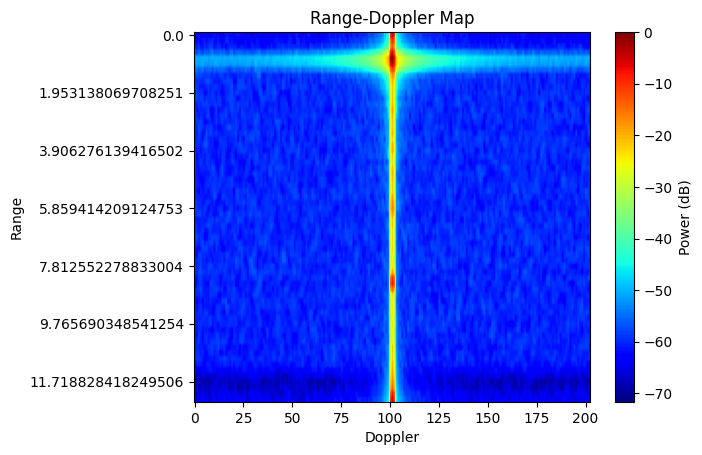

0.1953138069708251
(64, 203)


In [9]:
moving_back_test = h5py.File('../4022S_data/undergrad_testset/Experiment_moving_target_back_data.hdf5', 'r') # Read in the file
one_meter_centre_test = h5py.File('../4022S_data/undergrad_testset/Experiment_stationary_target_1m_1_data.hdf5','r')
two_meter_centre_test = h5py.File('../4022S_data/undergrad_testset/Experiment_stationary_target_2m_1_data.hdf5','r')
initial_slow_test_1 = h5py.File('../4022S_data/golfball_testset1/Experiment_2024-09-13_14-13-34_932_initialgolftest_slow.hdf5')
initial_slow_test_6 = h5py.File('../4022S_data/golfball_testset1/Experiment_2024-09-13_14-15-40_120_initialgolftest_slow.hdf5')
initial_fast_test_5 = h5py.File('../4022S_data/golfball_testset1/Experiment_2024-09-13_14-19-20_774_initialgolftest_fast.hdf5')

test_in_question = moving_back_test

freq_slope_const, number_of_samples_per_chirp, sample_rate, Tdata, bandwidth, range_bin_size = get_measurement_parameters(test_in_question)
range_doppler_data = range_doppler_map(test_in_question, '50', range_bin_size, 1)

print(range_bin_size)
print(range_doppler_data.shape)

C:\Users\harry\AppData\Local\Temp\ipykernel_26904\2254485639.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(x_ticks[::1]*range_bin_size)  # TODO: Copied this from the above version


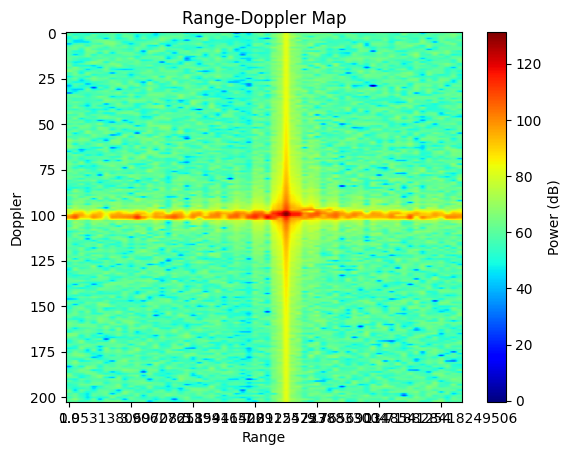

In [7]:
# Trying a homemade range-doppler map - can ignore this
target_frame = 'Sensors/TI_Radar/Data/Frame_10'
frame_data = test_in_question[f'{target_frame}/frame_data']#[:,:,0]


# Not really sure what Im doing here that doesnt let me do it on one frame?
# Cant remember what I was doing when I wrote this
window = np.tile(np.hanning(frame_data.shape[1])[np.newaxis, :, np.newaxis], (frame_data.shape[0], 1, frame_data.shape[2]))


after_fast_time_fft = fft(window[:,:,0]*frame_data[:,:,0],frame_data.shape[0],0)
after_slow_time_fft = fftshift(fft(after_fast_time_fft, after_fast_time_fft.shape[1],1))

#Normalize to dB

range_doppler_map_diy = np.rot90(20 * np.log10(np.abs(after_slow_time_fft)), 3)

plt.figure()
plt.imshow(range_doppler_map_diy, aspect='auto', cmap='jet')
#plt.imshow(20 * np.log10(np.abs(after_slow_time_fft)), aspect='auto', cmap='jet')
plt.title('Range-Doppler Map')
x_ticks = plt.gca().get_xticks()
plt.gca().set_xticklabels(x_ticks[::1]*range_bin_size)  # TODO: Copied this from the above version
                                                        # need to cut off the labels
plt.xlabel('Range')
plt.ylabel('Doppler')
plt.colorbar(label='Power (dB)')
plt.show()


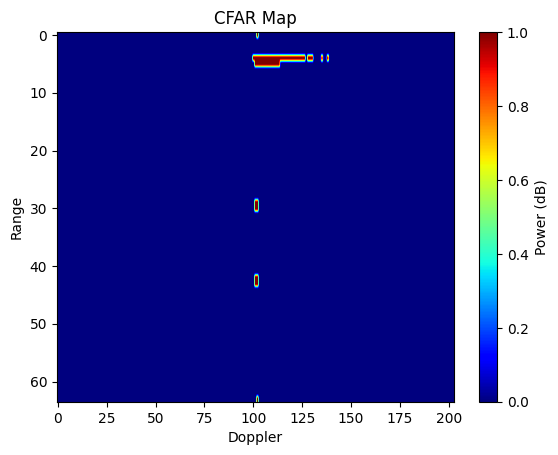

In [10]:
#cfar_output = cfar(np.abs(after_slow_time_fft), 15, 5, 15, 5, 1e-5,0) # TODO inspect and see how to determine this
cfar_output = cfar((10**(range_doppler_data/20)), 3, 3, 2, 2, 1e-4,0)

plt.figure()
plt.imshow(cfar_output, aspect='auto', cmap='jet')
#plt.imshow(20 * np.log10(np.abs(after_slow_time_fft)), aspect='auto', cmap='jet')
plt.title('CFAR Map')

plt.xlabel('Doppler')
plt.ylabel('Range')
plt.colorbar(label='Power (dB)')

plt.show()

#TODO:  Spectrogram gen: dont use inbuilt
#       Do from 1st prince
#TODO:  Velocity resolution typically 1/observation_period